In [1]:
import urllib.request
from tqdm import tqdm
import pandas as pd
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from sanbomics.tools import id_map



In [2]:
#loaf files

counts = pd.read_csv('GSE139580_Raw_counts.txt',sep='\t', )
metadata = pd.read_csv('SraRunTable.csv')
pd.DataFrame(counts) 
pd.DataFrame(metadata)
print(metadata)
print(counts)

            Run Assay Type  AvgSpotLen       Bases   BioProject     BioSample  \
0   SRR10363099    RNA-Seq          50  1076319800  PRJNA580367  SAMN13155854   
1   SRR10363100    RNA-Seq          50  1187457550  PRJNA580367  SAMN13155853   
2   SRR10363101    RNA-Seq          50  1051717150  PRJNA580367  SAMN13155852   
3   SRR10363102    RNA-Seq          50  1061309750  PRJNA580367  SAMN13155851   
4   SRR10363103    RNA-Seq          50  1177301550  PRJNA580367  SAMN13155850   
5   SRR10363104    RNA-Seq          50  1138573700  PRJNA580367  SAMN13155849   
6   SRR10363105    RNA-Seq          50  1008413950  PRJNA580367  SAMN13155848   
7   SRR10363106    RNA-Seq          50  1051331400  PRJNA580367  SAMN13155847   
8   SRR10363107    RNA-Seq          50   973003000  PRJNA580367  SAMN13155846   
9   SRR10363108    RNA-Seq          50  1047920250  PRJNA580367  SAMN13155845   
10  SRR10363109    RNA-Seq          50   966581850  PRJNA580367  SAMN13155844   
11  SRR10363110    RNA-Seq  

In [3]:
#set the index to the genes column  
counts = counts.set_index('gene_id')
counts

,KO_0dyn_rep1,KO_0dyn_rep2,KO_0dyn_rep3,KO_2dyn_rep1,KO_2dyn_rep2,KO_2dyn_rep3,KO_30dyn_rep1,KO_30dyn_rep2,KO_30dyn_rep3,WT_0dyn_rep1,WT_0dyn_rep2,WT_0dyn_rep3,WT_2dyn_rep1,WT_2dyn_rep2,WT_2dyn_rep3,WT_30dyn_rep1,WT_30dyn_rep2,WT_30dyn_rep3
gene_id,,,,,,,,,,,,,,,,,,
ENSMUSG00000025903,598,650,670,882,882,883,921,941,954,566,541,604,1162,1010,1117,1031,1189,1162
ENSMUSG00000033813,365,410,363,342,374,383,398,439,414,387,356,410,540,456,472,501,522,559
ENSMUSG00000033793,1437,1602,1445,2012,2053,2177,1601,1611,1501,708,705,817,1232,989,1071,917,955,1027
ENSMUSG00000025905,5,1,1,10,6,2,1,2,0,0,0,0,1,0,0,0,0,0
ENSMUSG00000025907,1190,1361,1208,1874,1922,1910,1742,1785,1697,1191,1085,1261,1266,1320,1396,1445,1680,1558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095867,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000094660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000095650,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [4]:
#remove columns with zero counts  

counts = counts[counts.sum(axis=1) > 0]
counts

,KO_0dyn_rep1,KO_0dyn_rep2,KO_0dyn_rep3,KO_2dyn_rep1,KO_2dyn_rep2,KO_2dyn_rep3,KO_30dyn_rep1,KO_30dyn_rep2,KO_30dyn_rep3,WT_0dyn_rep1,WT_0dyn_rep2,WT_0dyn_rep3,WT_2dyn_rep1,WT_2dyn_rep2,WT_2dyn_rep3,WT_30dyn_rep1,WT_30dyn_rep2,WT_30dyn_rep3
gene_id,,,,,,,,,,,,,,,,,,
ENSMUSG00000025903,598,650,670,882,882,883,921,941,954,566,541,604,1162,1010,1117,1031,1189,1162
ENSMUSG00000033813,365,410,363,342,374,383,398,439,414,387,356,410,540,456,472,501,522,559
ENSMUSG00000033793,1437,1602,1445,2012,2053,2177,1601,1611,1501,708,705,817,1232,989,1071,917,955,1027
ENSMUSG00000025905,5,1,1,10,6,2,1,2,0,0,0,0,1,0,0,0,0,0
ENSMUSG00000025907,1190,1361,1208,1874,1922,1910,1742,1785,1697,1191,1085,1261,1266,1320,1396,1445,1680,1558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000096768,39,29,40,31,57,43,65,75,59,213,202,263,220,176,177,160,184,183
ENSMUSG00000068457,67,72,78,97,82,104,49,77,60,608,527,704,596,601,622,516,592,547
ENSMUSG00000069045,169,202,173,225,221,201,163,190,152,1149,1022,1224,1198,1168,1323,1068,1246,1194


In [5]:
#pyDESeq requires counts matrix with rows as samples and genes as columns (transpose)  

counts = counts.T
counts.head(50)

gene_id,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000033793,ENSMUSG00000025905,ENSMUSG00000025907,ENSMUSG00000087247,ENSMUSG00000033740,ENSMUSG00000051285,ENSMUSG00000061024,ENSMUSG00000025911,...,ENSMUSG00000056673,ENSMUSG00000069049,ENSMUSG00000095852,ENSMUSG00000096520,ENSMUSG00000095153,ENSMUSG00000096768,ENSMUSG00000068457,ENSMUSG00000069045,ENSMUSG00000069044,ENSMUSG00000095650
KO_0dyn_rep1,598,365,1437,5,1190,0,5,1296,454,68,...,69,76,0,0,0,39,67,169,2,0
KO_0dyn_rep2,650,410,1602,1,1361,0,5,1464,494,75,...,79,104,0,0,0,29,72,202,0,0
KO_0dyn_rep3,670,363,1445,1,1208,2,1,1366,482,76,...,67,76,0,0,0,40,78,173,0,0
KO_2dyn_rep1,882,342,2012,10,1874,1,3,1156,618,136,...,119,94,0,0,0,31,97,225,2,0
KO_2dyn_rep2,882,374,2053,6,1922,2,2,1168,608,129,...,110,80,0,0,1,57,82,221,0,0
KO_2dyn_rep3,883,383,2177,2,1910,1,1,1134,611,134,...,128,102,0,0,0,43,104,201,1,0
KO_30dyn_rep1,921,398,1601,1,1742,2,1,1042,820,20,...,83,71,0,0,0,65,49,163,2,0
KO_30dyn_rep2,941,439,1611,2,1785,2,0,1093,816,36,...,88,74,0,0,0,75,77,190,0,0
KO_30dyn_rep3,954,414,1501,0,1697,4,0,1024,810,31,...,75,64,0,0,0,59,60,152,1,0
WT_0dyn_rep1,566,387,708,0,1191,0,0,398,392,18,...,655,805,2,8,0,213,608,1149,0,0


In [6]:
#prepare metadata using the counts index

metadata_df = pd.DataFrame(zip(counts.index, [   'KO_0dyn', 'KO_0dyn', 'KO_0dyn',
    'KO_2dyn', 'KO_2dyn', 'KO_2dyn',
    'KO_30dyn', 'KO_30dyn', 'KO_30dyn',
    'WT_0dyn', 'WT_0dyn', 'WT_0dyn',
    'WT_2dyn', 'WT_2dyn', 'WT_2dyn',
    'WT_30dyn', 'WT_30dyn', 'WT_30dyn']), columns = ['Sample','Condition'])


In [7]:
#set the sample column as the index
metadata_df = metadata_df.set_index('Sample')
metadata_df

,Condition
Sample,
KO_0dyn_rep1,KO_0dyn
KO_0dyn_rep2,KO_0dyn
KO_0dyn_rep3,KO_0dyn
KO_2dyn_rep1,KO_2dyn
KO_2dyn_rep2,KO_2dyn
KO_2dyn_rep3,KO_2dyn
KO_30dyn_rep1,KO_30dyn
KO_30dyn_rep2,KO_30dyn
KO_30dyn_rep3,KO_30dyn


In [8]:
#DESeq data object  
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts,
    metadata=metadata_df,
    design_factors="Condition",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

/opt/anaconda3/envs/gene_expression/lib/python3.12/site-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [9]:
#Run deseq2
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.65 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 2.93 seconds.

Fitting LFCs...
... done in 1.56 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



In [10]:
#dds.obs.Condition
dds


AnnData object with n_obs × n_vars = 18 × 17710
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [11]:
# stats

stats_res = DeseqStats(dds, contrast=('Condition','KO-0dyn','WT-0dyn'))

In [12]:
stats_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition KO-0dyn vs WT-0dyn
                       baseMean  log2FoldChange     lfcSE       stat  \
gene_id                                                                
ENSMUSG00000025903   864.427007        0.319183  0.065789   4.851616   
ENSMUSG00000033813   423.257754        0.134358  0.075407   1.781759   
ENSMUSG00000033793  1347.132609        1.161564  0.055542  20.913158   
ENSMUSG00000025905     1.675489        3.826113  2.162003   1.769707   
ENSMUSG00000025907  1499.537286        0.240434  0.053206   4.518906   
...                         ...             ...       ...        ...   
ENSMUSG00000096768   117.485044       -2.491420  0.171255 -14.548007   
ENSMUSG00000068457   311.305417       -2.925411  0.118908 -24.602217   
ENSMUSG00000069045   639.096733       -2.488611  0.081095 -30.687760   
ENSMUSG00000069044     0.493184        2.028119  2.768312   0.732619   
ENSMUSG00000095650     0.049929       -0.810116  5.539875  -0.146234 

... done in 2.60 seconds.



In [13]:
#stats 
res = stats_res.results_df
res #Differentially expressd df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSMUSG00000025903,864.427007,0.319183,0.065789,4.851616,1.224594e-06,2.170271e-06
ENSMUSG00000033813,423.257754,0.134358,0.075407,1.781759,7.478853e-02,9.289895e-02
ENSMUSG00000033793,1347.132609,1.161564,0.055542,20.913158,4.064219e-97,3.424150e-96
ENSMUSG00000025905,1.675489,3.826113,2.162003,1.769707,7.677594e-02,9.513859e-02
ENSMUSG00000025907,1499.537286,0.240434,0.053206,4.518906,6.215992e-06,1.058253e-05
...,...,...,...,...,...,...
ENSMUSG00000096768,117.485044,-2.491420,0.171255,-14.548007,6.012987e-48,2.774355e-47
ENSMUSG00000068457,311.305417,-2.925411,0.118908,-24.602217,1.196023e-133,1.462099e-132
ENSMUSG00000069045,639.096733,-2.488611,0.081095,-30.687760,8.290322e-207,1.676325e-205


In [14]:
#mapper for ENSMBL_ID's
mapper = id_map(species='mouse')

In [15]:
#new column with gene ENSMBL ID's
#mapper.mapper
res['Gene_Symbol'] =  res.index.map(mapper.mapper)

In [16]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene_Symbol
gene_id,,,,,,,
ENSMUSG00000025903,864.427007,0.319183,0.065789,4.851616,1.224594e-06,2.170271e-06,Lypla1
ENSMUSG00000033813,423.257754,0.134358,0.075407,1.781759,7.478853e-02,9.289895e-02,Tcea1
ENSMUSG00000033793,1347.132609,1.161564,0.055542,20.913158,4.064219e-97,3.424150e-96,Atp6v1h
ENSMUSG00000025905,1.675489,3.826113,2.162003,1.769707,7.677594e-02,9.513859e-02,Oprk1
ENSMUSG00000025907,1499.537286,0.240434,0.053206,4.518906,6.215992e-06,1.058253e-05,Rb1cc1
...,...,...,...,...,...,...,...
ENSMUSG00000096768,117.485044,-2.491420,0.171255,-14.548007,6.012987e-48,2.774355e-47,Gm47283
ENSMUSG00000068457,311.305417,-2.925411,0.118908,-24.602217,1.196023e-133,1.462099e-132,Uty
ENSMUSG00000069045,639.096733,-2.488611,0.081095,-30.687760,8.290322e-207,1.676325e-205,Ddx3y


In [17]:
#filter out stuff that is lowly expressed  

res = res[res.baseMean >= 10]

res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene_Symbol
gene_id,,,,,,,
ENSMUSG00000025903,864.427007,0.319183,0.065789,4.851616,1.224594e-06,2.170271e-06,Lypla1
ENSMUSG00000033813,423.257754,0.134358,0.075407,1.781759,7.478853e-02,9.289895e-02,Tcea1
ENSMUSG00000033793,1347.132609,1.161564,0.055542,20.913158,4.064219e-97,3.424150e-96,Atp6v1h
ENSMUSG00000025907,1499.537286,0.240434,0.053206,4.518906,6.215992e-06,1.058253e-05,Rb1cc1
ENSMUSG00000051285,816.830516,1.974969,0.062826,31.435544,6.616080e-217,1.438901e-215,Pcmtd1
...,...,...,...,...,...,...,...
ENSMUSG00000056673,385.991656,-3.127072,0.118085,-26.481555,1.581033e-154,2.287911e-153,Kdm5d
ENSMUSG00000069049,440.405259,-3.103548,0.105533,-29.408287,4.302824e-190,7.794570e-189,Eif2s3y
ENSMUSG00000096768,117.485044,-2.491420,0.171255,-14.548007,6.012987e-48,2.774355e-47,Gm47283


In [18]:
#significance  

sig = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene_Symbol
gene_id,,,,,,,
ENSMUSG00000033793,1347.132609,1.161564,0.055542,20.913158,4.064219e-97,3.424150e-96,Atp6v1h
ENSMUSG00000051285,816.830516,1.974969,0.062826,31.435544,6.616080e-217,1.438901e-215,Pcmtd1
ENSMUSG00000025911,46.962928,2.347825,0.263256,8.918398,4.730830e-19,1.289388e-18,Adhfe1
ENSMUSG00000025915,175.388200,-8.153822,0.837750,-9.733001,2.180629e-22,6.409106e-22,Sgk3
ENSMUSG00000056763,693.579775,-0.665238,0.067754,-9.818500,9.372778e-23,2.774928e-22,Cspp1
...,...,...,...,...,...,...,...
ENSMUSG00000056673,385.991656,-3.127072,0.118085,-26.481555,1.581033e-154,2.287911e-153,Kdm5d
ENSMUSG00000069049,440.405259,-3.103548,0.105533,-29.408287,4.302824e-190,7.794570e-189,Eif2s3y
ENSMUSG00000096768,117.485044,-2.491420,0.171255,-14.548007,6.012987e-48,2.774355e-47,Gm47283


In [124]:
#PCA plot with scanpy

#scanpy uses numpy older version

%pip install numpy==2.0
import numpy as np
print(np.__version__)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 3.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.
2.1.3


In [19]:
import scanpy as sc

In [20]:
#PCA plot 

sc.tl.pca(dds)

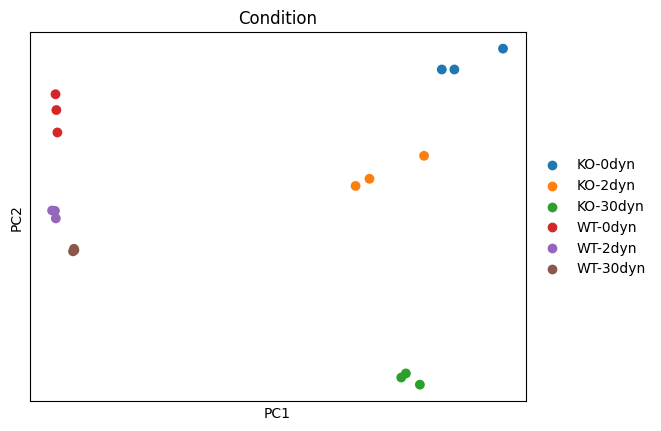

In [21]:
sc.pl.pca(dds, color='Condition', size=200)

In [24]:
#GSEA 

import gseapy as gp 
from gseapy.plot import gseaplot

In [42]:
#new df from res called ranking 

ranking = res[['Gene_Symbol','stat']].dropna().sort_values('stat', ascending=False) #largest on top
ranking = ranking.reset_index().drop(columns=['gene_id'])
ranking

,Gene_Symbol,stat
0,Col6a2,97.891616
1,Col5a1,93.528443
2,Calu,89.940793
3,Grn,88.366008
4,Col3a1,86.909305
...,...,...
12411,Ivns1abp,-72.001634
12412,Pcsk9,-72.630069
12413,Bicc1,-79.865055
12414,Col18a1,-96.368619


In [43]:
#drop duplicates  (usually a couple of genes doesnt impact overall)

ranking = ranking.drop_duplicates('Gene_Symbol')
ranking

,Gene_Symbol,stat
0,Col6a2,97.891616
1,Col5a1,93.528443
2,Calu,89.940793
3,Grn,88.366008
4,Col3a1,86.909305
...,...,...
12411,Ivns1abp,-72.001634
12412,Pcsk9,-72.630069
12413,Bicc1,-79.865055
12414,Col18a1,-96.368619


In [44]:
#get the gene libraries
gp.get_library_name(organism='Mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [50]:
#GSEA 
ranking = ranking.copy()
#convert gene symbols uppercase 

ranking['Gene_Symbol'] = ranking['Gene_Symbol'].str.upper()




In [51]:
pre_res = gp.prerank(rnk=ranking, 
                    gene_sets='GO_Biological_Process_2023', 
                     seed= 6, 
                     permutation_num=1000)

In [55]:
pre_res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,DNA-templated DNA Replication (GO:0006261),-0.689043,-2.656349,0.0,0.0,0.0,34/68,13.21%,MCM7;MCM6;MCM2;MCM5;MCM3;BLM;POLD1;RFC5;RRM1;M...
1,prerank,Extracellular Matrix Organization (GO:0030198),0.652884,2.525769,0.0,0.0,0.0,51/108,11.91%,COL5A1;COL3A1;MMP14;FLRT2;NID2;CYP1B1;COL1A2;C...
2,prerank,DNA Metabolic Process (GO:0006259),-0.533795,-2.518063,0.0,0.0,0.0,126/274,21.74%,MCM7;LIG1;MCM6;TRIM28;MCM2;PARP1;RAD21;PCLAF;M...
3,prerank,DNA Replication (GO:0006260),-0.645077,-2.504238,0.0,0.0,0.0,35/71,13.71%,MCM7;MCM6;MCM2;PCLAF;MCM5;BLM;CDK2;CDK1;BAZ1A;...
4,prerank,Extracellular Structure Organization (GO:0043062),0.69268,2.444559,0.0,0.0,0.0,25/60,8.51%,COL5A1;COL3A1;MMP14;COL1A2;COL16A1;COL1A1;MATN...
5,prerank,External Encapsulating Structure Organization ...,0.685551,2.422916,0.0,0.0,0.0,24/60,8.51%,COL5A1;COL3A1;MMP14;COL1A2;COL16A1;COL1A1;MATN...
6,prerank,Sister Chromatid Segregation (GO:0000819),-0.688225,-2.329205,0.0,0.0,0.0,17/33,10.45%,SMC4;KLHL22;NCAPG2;RB1;TOP2A;KNTC1;SPAG5;PLK1;...
7,prerank,Sterol Biosynthetic Process (GO:0016126),-0.746764,-2.318838,0.0,0.0,0.0,17/25,10.83%,CYP51A1;SQLE;LSS;HMGCS1;LBR;HMGCR;DHCR7;ACLY;P...
8,prerank,DNA Unwinding Involved In DNA Replication (GO:...,-0.772013,-2.264753,0.0,0.000354,0.002,11/20,10.89%,MCM7;MCM6;MCM2;MCM5;MCM3;MCM4;RAD51;CDC45;GINS...
9,prerank,DNA Replication Checkpoint Signaling (GO:0000076),-0.814776,-2.255959,0.0,0.000608,0.004,8/16,5.44%,TIMELESS;CDC6;TICRR;DNA2;CDT1;CDC45;TOPBP1;CLSPN


In [57]:
#function to grab the Term, fdr, es, nes columns fro  the pre_res object  

out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
                pre_res.results[term]['es'],
                pre_res.results[term]['nes']])
    
    out_df = pd.DataFrame(out, columns =['Term','fdr','es','nes']).sort_values('fdr').reset_index(drop=True)
out_df

,Term,fdr,es,nes
0,Sister Chromatid Segregation (GO:0000819),0.0,-0.688225,-2.329205
1,DNA Replication (GO:0006260),0.0,-0.645077,-2.504238
2,Extracellular Structure Organization (GO:0043062),0.0,0.692680,2.444559
3,Collagen Fibril Organization (GO:0030199),0.0,0.674338,2.214348
4,Extracellular Matrix Organization (GO:0030198),0.0,0.652884,2.525769
...,...,...,...,...
2078,Metallo-Sulfur Cluster Assembly (GO:0031163),1.0,0.149910,0.441095
2079,mRNA Transcription (GO:0009299),1.0,-0.145562,-0.495924
2080,Iron-Sulfur Cluster Assembly (GO:0016226),1.0,0.149910,0.441095
2081,rRNA Methylation (GO:0031167),1.0,0.166896,0.444479


In [63]:
#sort

first_term = out_df.sort_values('nes').iloc[0].Term #normalized enrichment score
out_df.sort_values('nes')
#first_term

,Term,fdr,es,nes
6,DNA-templated DNA Replication (GO:0006261),0.0,-0.689043,-2.656349
8,DNA Metabolic Process (GO:0006259),0.0,-0.533795,-2.518063
1,DNA Replication (GO:0006260),0.0,-0.645077,-2.504238
0,Sister Chromatid Segregation (GO:0000819),0.0,-0.688225,-2.329205
9,Sterol Biosynthetic Process (GO:0016126),0.0,-0.746764,-2.318838
...,...,...,...,...
3,Collagen Fibril Organization (GO:0030199),0.0,0.674338,2.214348
7,Negative Regulation Of Peptidase Activity (GO:...,0.0,0.753097,2.221286
5,External Encapsulating Structure Organization ...,0.0,0.685551,2.422916
2,Extracellular Structure Organization (GO:0043062),0.0,0.692680,2.444559


[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

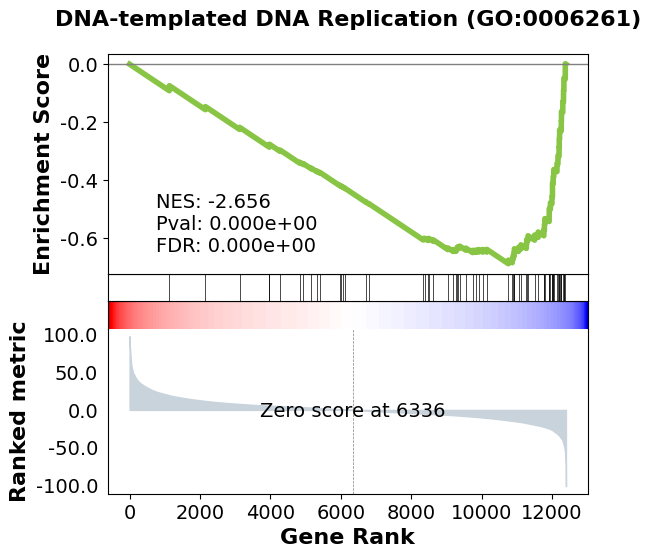

In [72]:
#first term GSEA 'DNA-templated DNA Replication (GO:0006261)'

gseaplot(rank_metric= pre_res.ranking, #documentation
        term= 'DNA-templated DNA Replication (GO:0006261)',
        **pre_res.results['DNA-templated DNA Replication (GO:0006261)'])